In [800]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [801]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import Callback, EarlyStopping

In [802]:
input_dir = 'input'
subdirs = [d for d in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, d))]
labels = []
for subdir in subdirs:
    subdir_path = os.path.join(input_dir, subdir)
    print(subdir_path)
    files = os.listdir(subdir_path)
    for file in files:
        full_path = os.path.join(subdir_path, file)
        labels.append((full_path, subdir))


data = pd.DataFrame(labels, columns=['filename', 'label'])
data = data.sample(frac=1).reset_index(drop=True)


input\bishop_resized
input\knight-resize
input\pawn_resized
input\Queen-Resized
input\Rook-resize


In [803]:
from sklearn.model_selection import train_test_split


train_df, test_df = train_test_split(data, test_size=0.2, random_state=1)

In [804]:

#Todo, fiddle with this.
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

class_count_train = train_df['label'].value_counts().to_dict()
class_count_test = test_df['label'].value_counts().to_dict()
def setup(preprocess=False):
    if preprocess:
        target_size = (100,100)

        augmented_train = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        validation_split=0.2)

        augmented_test = ImageDataGenerator(
        preprocessing_function=preprocess_input)
    else:
        target_size = (224,224)
        
        augmented_train = ImageDataGenerator(
            #rotation_range=10,
            #width_shift_range=0.1,
            #height_shift_range=0.1,
            #shear_range=0,
            horizontal_flip=True,
            #zoom_range=0.225,
            rescale=1/255,
            validation_split=0.2)

        augmented_test = ImageDataGenerator(
            #rotation_range=10,
            #width_shift_range=0.1,
            #height_shift_range=0.1,
            #shear_range=0,
            horizontal_flip=True,
            #zoom_range=0.225,
            rescale=1/255)
    
    train = augmented_train.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='label',
    target_size=target_size,#check here
    subset="training",
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=0,
    horizontal_flip=True,
    fill_mode="nearest",
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
)
    val = augmented_train.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='label',
    target_size=target_size,#check here
    subset="validation",
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    seed=0,
    horizontal_flip=True,
    fill_mode="nearest",
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    #shuffle=True
)

    test = augmented_test.flow_from_dataframe(
    dataframe=test_df,
    shuffle=False,
    x_col='filename',
    y_col='label',
    target_size=target_size,#check here
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    seed=0,
    verbose=0,
    #chelck
)
    
    return train, val, test
train, val, test = setup()
train_1, val_1, test_1 = setup(preprocess=True)

Found 411 validated image filenames belonging to 5 classes.


Found 102 validated image filenames belonging to 5 classes.
Found 129 validated image filenames belonging to 5 classes.
Found 411 validated image filenames belonging to 5 classes.
Found 102 validated image filenames belonging to 5 classes.
Found 129 validated image filenames belonging to 5 classes.


In [805]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, regularizers
#from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Dropout
#from tensorflow.keras.applications import MobileNetV2

model = Sequential([
    Conv2D(32, (3, 3), input_shape=(224, 224, 3)),
    #BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    #Dropout(0.2),
    
    Conv2D(64, (3, 3)),
    #BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3)),
    #BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(64),
    Activation('relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])


In [806]:
from sklearn.utils.class_weight import compute_class_weight

classes = list(class_count_train.keys())
print(class_count_train)
y = np.concatenate([[i] * class_count_train[klass] for i, klass in enumerate(classes)])
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
weight_dict = {i: weight for i, weight in enumerate(weights)}
print(weight_dict)

{'knight-resize': 134, 'bishop_resized': 113, 'Rook-resize': 111, 'Queen-Resized': 94, 'pawn_resized': 61}
{0: 0.7656716417910447, 1: 0.9079646017699115, 2: 0.9243243243243243, 3: 1.0914893617021277, 4: 1.681967213114754}


In [807]:

"""
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),#todo, consider changing logits
              metrics=['accuracy'])
#callback commented out
callback = [EarlyStopping(monitor='val_accuracy', patience = 0.8, restore_best_weights=True)]#tweak patience

history = model.fit(train, class_weight=weight_dict, epochs=10, 
validation_data=val, callbacks=callback)
"""

#here we see the accuracy and validation accuracy over time. Please note we have a halting mechanism in place
#print(report(model, "Liam"))


"\nmodel.compile(optimizer='adam',\n              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),#todo, consider changing logits\n              metrics=['accuracy'])\n#callback commented out\ncallback = [EarlyStopping(monitor='val_accuracy', patience = 0.8, restore_best_weights=True)]#tweak patience\n\nhistory = model.fit(train, class_weight=weight_dict, epochs=10, \nvalidation_data=val, callbacks=callback)\n"

In [808]:
    

#history = model.fit(train, epochs=25, 
                  #  validation_data=(val), steps_per_epoch=train.samples//32,validation_steps=val.samples//32)

import matplotlib.pyplot as plt
"""
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
"""


"\nplt.plot(history.history['accuracy'], label='accuracy')\nplt.plot(history.history['val_accuracy'], label = 'val_accuracy')\nplt.xlabel('Epoch')\nplt.ylabel('Accuracy')\nplt.ylim([0, 1])\nplt.legend(loc='lower right')\n"

In [809]:
#Here we see how we truly do for labeling each of the images, Note, augmented images are augmented.
from sklearn.metrics import classification_report

def report(this_model, name):
    test.reset()
    if name == "Liam":
        true_labels = test_df.label
        print(true_labels)
        predictions = this_model.predict(test)
    else:
        true_labels = test_df.label
        predictions = this_model.predict(test_1)
    predictions = np.argmax(predictions, axis=1)
    labels = (train.class_indices)
    labels = dict((i,j) for j,i in labels.items())
    pred_classes = [labels[i] for i in predictions]
    report = classification_report(true_labels, 
                                   pred_classes)
    return report

In [810]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
#pretrained model 
mobile_model = MobileNetV2(input_shape=(100,100, 3),
                include_top=False,
                weights='imagenet',
                pooling='avg')
mobile_model.trainable = False
inputs = mobile_model.input
x = Dense(64, activation='relu')(mobile_model.output)
x = Dense(64, activation='relu')(x)
outputs = Dense(5, activation='softmax')(x)
mobile = Model(inputs=inputs, outputs=outputs)
mobile.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
callback  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              mode='auto')]
history = mobile.fit(train_1, validation_data=val_1, epochs=100,callbacks=callback,verbose=1, class_weight=weight_dict);
                    


Epoch 1/100
13/13 [==============================] - 6s 247ms/step - loss: 1.5945 - accuracy: 0.3528 - val_loss: 1.3938 - val_accuracy: 0.4020
Epoch 2/100
13/13 [==============================] - 2s 162ms/step - loss: 0.8763 - accuracy: 0.7105 - val_loss: 1.0467 - val_accuracy: 0.5980
Epoch 3/100
13/13 [==============================] - 2s 155ms/step - loss: 0.5514 - accuracy: 0.8151 - val_loss: 0.8781 - val_accuracy: 0.7255
Epoch 4/100
13/13 [==============================] - 2s 148ms/step - loss: 0.3709 - accuracy: 0.8905 - val_loss: 0.8264 - val_accuracy: 0.7353
Epoch 5/100
13/13 [==============================] - 2s 153ms/step - loss: 0.2561 - accuracy: 0.9440 - val_loss: 0.8163 - val_accuracy: 0.7255
Epoch 6/100
13/13 [==============================] - 2s 177ms/step - loss: 0.1826 - accuracy: 0.9708 - val_loss: 0.8632 - val_accuracy: 0.6569
Epoch 7/100
13/13 [==============================] - 2s 154ms/step - loss: 0.1262 - accuracy: 0.9708 - val_loss: 0.8072 - val_accuracy: 0.7157

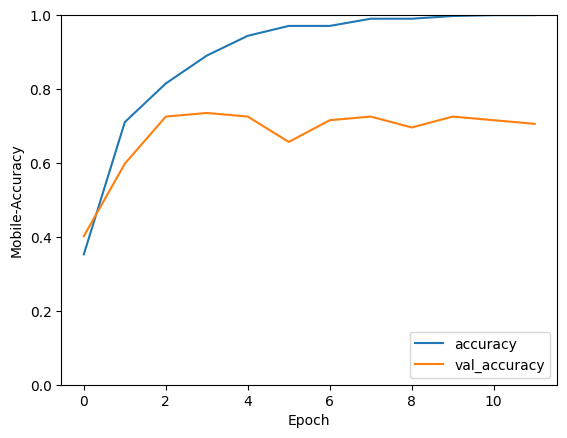

In [811]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Mobile-Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [812]:

print("_______________Liams Model__________________")
#print(report(model, "Liam"))
print("_______________Mobile Net___________________")
print(report(mobile, "Mobile"))

_______________Liams Model__________________
_______________Mobile Net___________________
5/5 [==============================] - 1s 122ms/step
                precision    recall  f1-score   support

 Queen-Resized       0.73      0.55      0.63        20
   Rook-resize       0.86      0.70      0.78        27
bishop_resized       0.61      0.79      0.69        28
 knight-resize       0.89      0.94      0.92        36
  pawn_resized       0.72      0.72      0.72        18

      accuracy                           0.77       129
     macro avg       0.77      0.74      0.75       129
  weighted avg       0.78      0.77      0.77       129

